<a href="https://colab.research.google.com/github/skmisht/CNN/blob/main/CNN_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Melanoma detection - PyTorch 

In [7]:
import os
import shutil
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import matplotlib.image as img
%matplotlib inline
# torch
import torch
print("Current Torch version: ", torch.__version__)
# to install if there is no latest version of torch
# !pip install -q torch==1.0.0 
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
# test if the notebook is running on GPU
import tensorflow as tf
tf.test.gpu_device_name()

Current Torch version:  1.7.0+cu101


'/device:GPU:0'

In [ ]:
# # accessing data files from google drive
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# # moving training meta data 
# shutil.move("/content/drive/MyDrive/Melanoma/ISIC-2017_Training/ISIC-2017_Training_Data/ISIC-2017_Training_Data_metadata.csv",
#             "/content/drive/MyDrive/Melanoma")
# # validation meta data
# shutil.move("/content/drive/MyDrive/Melanoma/ISIC-2017_Validation/ISIC-2017_Validation_Data/ISIC-2017_Validation_Data_metadata.csv",
#             "/content/drive/MyDrive/Melanoma")

In [8]:
# list of files in Melanoma folder
# !ls '/content/drive/My Drive/Melanoma'

base_dir = '/content/drive/My Drive/Melanoma'
for file in os.listdir(base_dir):
  if os.path.isdir(os.path.join(base_dir, file)) or os.path.isfile(os.path.join(base_dir, file)):
    print(file)

ISIC-2017_Test_v2_Data_metadata.csv
ISIC-2017_Validation_Part3_GroundTruth.csv
ISIC-2017_Training_Part3_GroundTruth.csv
ISIC-2017_Test_v2_Part3_GroundTruth.csv
ISIC-2017_Training
ISIC-2017_Test
ISIC-2017_Validation
ISIC-2017_Training_Data_metadata.csv
ISIC-2017_Validation_Data_metadata.csv


# Data files

In [23]:
# reading the melanoma labels - groundtruth csv's for train, validation, and test
train_labels = pd.read_csv('/content/drive/MyDrive/Melanoma/ISIC-2017_Training_Part3_GroundTruth.csv', delimiter=',', usecols=['image_id', 'melanoma'])
test_labels = pd.read_csv('/content/drive/MyDrive/Melanoma/ISIC-2017_Test_v2_Part3_GroundTruth.csv', delimiter=',', usecols=['image_id', 'melanoma'])
valid_labels = pd.read_csv('/content/drive/MyDrive/Melanoma/ISIC-2017_Validation_Part3_GroundTruth.csv', delimiter=',', usecols=['image_id', 'melanoma'])

# melanoma images
train_images = r'/content/drive/MyDrive/Melanoma/ISIC-2017_Training/ISIC-2017_Training_Data'
validation_images = r'/content/drive/MyDrive/Melanoma/ISIC-2017_Validation/ISIC-2017_Validation_Data' 
test_images = r'/content/drive/MyDrive/Melanoma/ISIC-2017_Test/ISIC-2017_Test_v2_Data'

# Image preprocessing
  - Peek at
    - first 5 images before preprocessing
    - last 5 images before preprocessing
  - Standardising image by mean and standard deviation

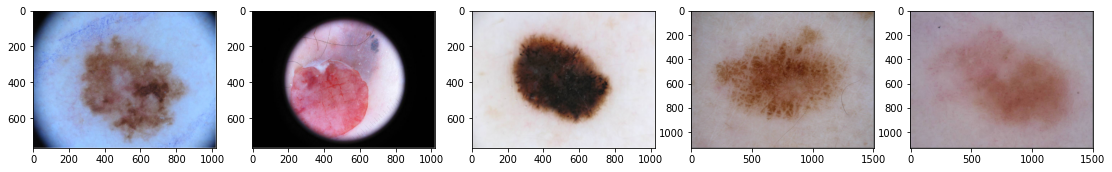

In [25]:
# peek at first 5 images from training set
fig,ax = plt.subplots(1,5,figsize = (19,5))

for i,idx in enumerate(labels[labels['melanoma'] == 1]['image_id'][:5]):
    path = os.path.join(train_images,idx) + '.jpg'
    ax[i].imshow(img.imread(path))

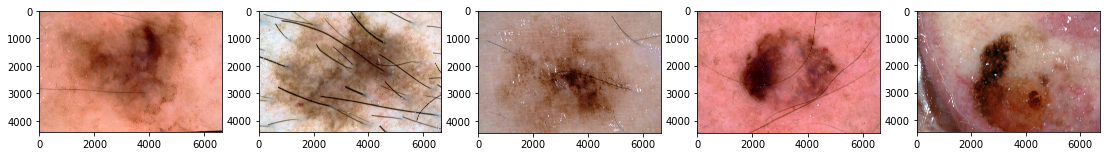

In [16]:
# peek at last 5 images from training set
import matplotlib.image as img
fig,ax = plt.subplots(1,5,figsize = (19,5))

for i,idx in enumerate(labels[labels['melanoma'] == 1]['image_id'][-5:]):
    path = os.path.join(train_images,idx) + '.jpg'
    ax[i].imshow(img.imread(path))

In [26]:
# Stadardised the image using mean and std
def ImageShow(image, ax=None, title=None, normalize=True):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax 

# Dataset for model

In [27]:
class ISICDataset(Dataset):
  # initialiser 
  def __init__(self, data, path, transform=None): 
    super().__init__()
    self.data = data.values
    self.path = path
    self.transform = transform

    def __len__(self):
      return len(self.data)

    def __getitem__(self, index):
      images, label = self.data[index]
      image_path = os.path.join(self.path, images)
      image = img.imread(image_path)
      # if transform is None
      if self.transform is not None:
        image = self.transform(image)

      return image, label

In [28]:
# Image Normalisation
train_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])])

test_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])])

valid_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])])

# Datsets
  - Train - fitting parameters to a classifier
  - Validadtion - to tune the hyperparameters sucb as learning rate, and epochs
  - Test - final evaluation of model

In [31]:
train_data = ISICDataset(train_labels, train_images, train_transform )
valid_data = ISICDataset(valid_labels, validation_images, valid_transform )
test_data = ISICDataset(test_labels, test_images, test_transform )

# DataLoader and hyperparameters
  - number of epochs
  - number of class
  - batch size
  - learning rate

In [34]:
# Hyperparameter values
num_epochs = 35
num_classes = 2
batch_size = 25
learning_rate = 0.001

# Dataloader - to combines a dataset and a sampler
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(dataset = valid_data, batch_size = batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle=False, num_workers=0)

TypeError: ignored